### MScFE 690 Capstone -- Submission 4

#### Install and imports

In [17]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'

The MMAR or Multifractal Model of Asset Returns utilizes a compound process denoted as \(X(t)\). This is presented mathematically as:

$$ X(t) = B_H(\theta(t)) $$

Here are the components of the equation:

- \(X(t)\) is our compound process. This signifies the cumulative effect of multiple time scales.
- \(B_H(t)\) is what we call a fractional Brownian motion. This is a variation of a Gaussian process and a generalization of the standard Brownian motion. The Hurst exponent, denoted by \(H\) (with \(0 < H < 1\)), characterizes this motion. A Hurst exponent of \(0.5\) turns \(B_H(t)\) into a standard Brownian motion, while a Hurst exponent less than \(0.5\) indicates negative correlation in the process increments, and a Hurst exponent greater than \(0.5\) suggests positive correlation.
- Lastly, \(\theta(t)\) corresponds to the cumulative distribution function of a specific multifractal cascade measure. This is crucial as it dictates the changing "pace" of the fractional Brownian motion. The precise form of \(\theta(t)\) is contingent on the multifractal cascade measure in use, which itself depends on the distinct properties of the financial time series under study.

#### A Look a Fractal Brownian Motion

In [18]:
fbm = nolds.fbm(100, H=0.75)

In [19]:
fbm = pd.Series(fbm)

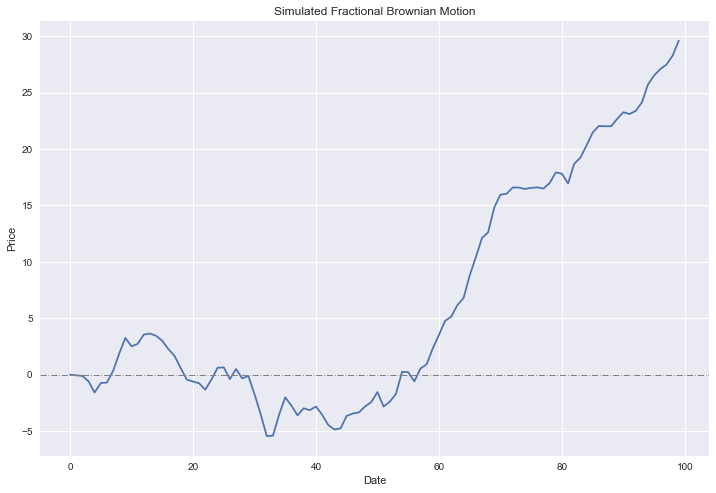

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(fbm)
plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion')
# plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### Importing Oil Prices

In [21]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-06-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [22]:
prices = data['Adj Close']

In [24]:
prices[-2000:]

Date
2015-07-20    50.150002
2015-07-21    50.360001
2015-07-22    49.189999
2015-07-23    48.450001
2015-07-24    48.139999
                ...    
2023-06-26    69.370003
2023-06-27    67.699997
2023-06-28    69.559998
2023-06-29    69.860001
2023-06-30    70.639999
Name: Adj Close, Length: 2000, dtype: float64

#### Calculating Oil's Hurst Exponent

In [25]:
oil_h = nolds.hurst_rs(prices)

In [26]:
oil_fd = nolds.corr_dim(prices, 1)

In [27]:
oil_h + oil_fd # D = H - 2

1.908261753245252

In [28]:
fbm_oil = nolds.fbm(100, H=oil_h)

In [29]:
fbm_oil = pd.Series(fbm_oil)

<AxesSubplot:>

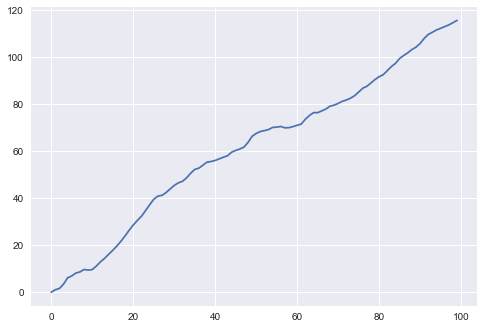

In [30]:
fbm_oil.plot()

#### Simulating A FBM with Oil's H

In [33]:
from fbm import FBM

# parameters
N = 100000
H = 0.60
S0 = 100  
K = 100  
T = 1.0  
r = 0.05  

# FBM object
f = FBM(n=N-1, hurst=H, length=T, method='daviesharte')

# Fractional Brownian motion 
fbm_sample = f.fbm()

# calculate its standard deviation as the volatility
sigma = np.std(fbm_sample)

# Create a function to simulate a price path
def simulate_path(S0, T, sigma, N, fbm_sample):
    dt = T/(N-1)
    return S0 * np.exp((r - 0.5*sigma**2)*np.linspace(0, T, N) + sigma*fbm_sample)

# paths
num_paths = 10000

# simulate price paths and calculate payoffs
payoffs = []
for _ in range(num_paths):
    path = simulate_path(S0, T, sigma, N, fbm_sample)
    payoff = np.maximum(path[-1] - K, 0)  # This is for a call option
    payoffs.append(payoff)

# Calculate the option price as the average discounted payoff
option_price = np.exp(-r*T) * np.mean(payoffs)

print("Option price: ", option_price)


Option price:  27.849392642468594


In [34]:
fbm_sample

array([0.00000000e+00, 7.17441853e-04, 6.19750806e-04, ...,
       8.01847289e-01, 8.02664141e-01, 8.02465772e-01])

#### Experimenting with different stochastic models

In [35]:
# Binomail Multifractal Model

In [ ]:
## Perhaps we can delete this model ****

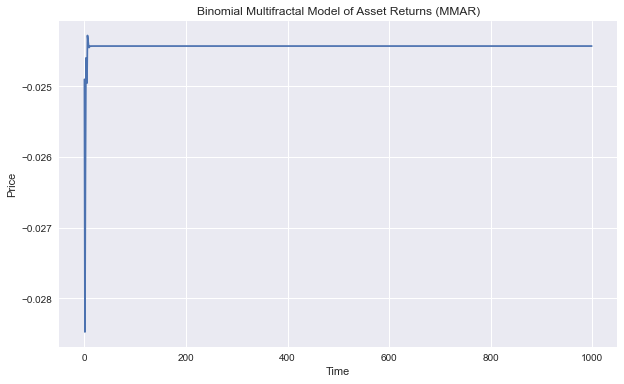

In [36]:
def binomial_multifractal_model(time, M, lambda_):
    """
    Binomial Multifractal Model

    Parameters:
    time: length of the time series
    M: large number for computation
    lambda_: a parameter of the model

    Returns:
    price: a time series represents a price following MMAR
    """
    alpha = 0.5 + lambda_/2.
    beta = 0.5 - lambda_/2.
    
    # Generate two binomial random variables
    p = np.random.binomial(n=1, p=0.5, size=(M, time)) * 2 - 1
    epsilon = np.random.binomial(n=1, p=0.5, size=(M, time)) * 2 - 1

    # Calculate multipliers
    multiplier = np.cumprod(np.where(p == 1, alpha, beta), axis=1)

    # Calculate price
    price = np.cumsum(multiplier * epsilon, axis=1)

    return price

# Set parameters
time = 1000
M = 1000
lambda_ = 0.1

# Generate price series
price = binomial_multifractal_model(time, M, lambda_)

# Average price series
average_price = price.mean(axis=0)

# Plot the average price series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(average_price)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Binomial Multifractal Model of Asset Returns (MMAR)")
plt.show()

### The Multifractal Model of Asset Returns

### The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} \xi_i $$

Here, each \( \xi_i \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( \xi_i \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( \tau \) is the time lag, and \( H \) is the Hurst exponent.


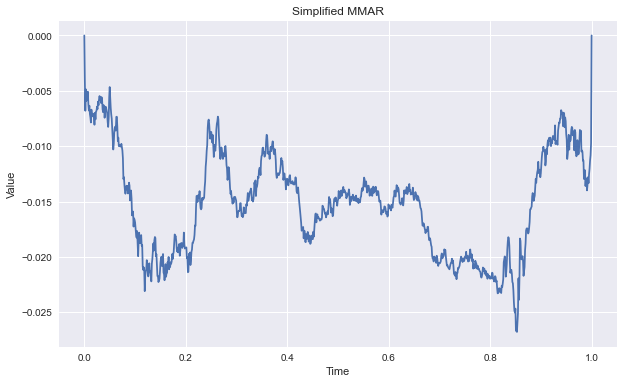

In [37]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

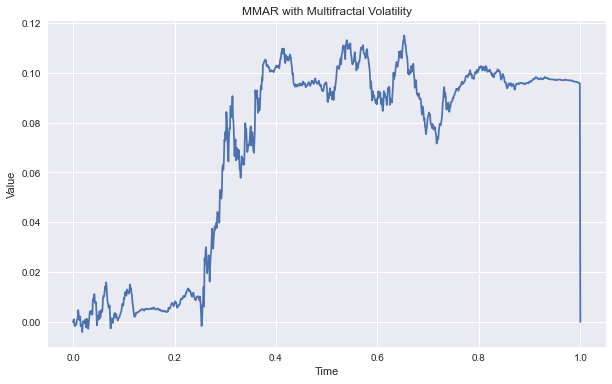

In [38]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MMAR with Multifractal Volatility')
plt.show()

#### The existing python package